# Réseaux de neurones sur MNIST
*Aude Sportisse*

In [1]:
!pip install torchvision

In [2]:
## Télécharger les librairies utiles

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
from torchvision import transforms

from torchvision import transforms

import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset

In [3]:
## Télécharger le jeu de données (il y a le jeu d'entrainement et le jeu de test)

MNIST_format = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(), 
                transforms.Normalize((0.5,), (1.0,))])

data_train = datasets.MNIST(root = "./datasets",train = True,download = True, transform = MNIST_format)
data_test = datasets.MNIST(root = "./datasets",train = False,download = True, transform = MNIST_format)

train_set = {"images": data_train.data, "labels": np.array(data_train.targets)} #jeu d'entrainement
test_set = {"images": data_test.data, "labels": np.array(data_test.targets)} #jeu de test

On peut regarder ce qu'est la première image et l'étiquette (label) associé.

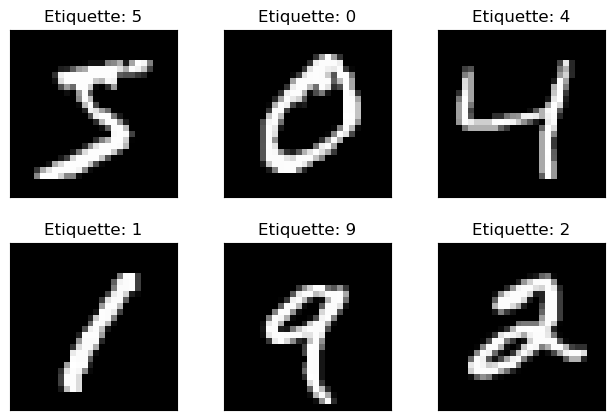

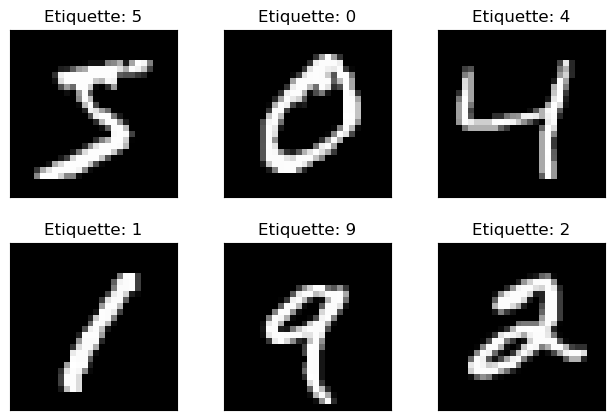

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set["images"][i].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Etiquette: {}".format(train_set["labels"][i]))
    plt.xticks([])
    plt.yticks([])
fig

# Choix du réseau de neurones

In [5]:
init_channel = 1 #Les images sont en noir et blanc
output_size = 10 #Le nombre de classe (0,1,2,3,4,5,6,7,8,9)

In [6]:
class Net(torch.nn.Module):
    def __init__(self,init_channel=init_channel):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(init_channel, 6, 5) 
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Entrainement du réseau sur le jeu d'entrainement

In [7]:
#######################################
########FONCTION D'ENTRAINEMENT########
#######################################

def train(model,optimizer,data_loaders,loss_train,epoch):
    
    c = 0 #c'est juste un compteur pour savoir quand les résultats sont affichés
    
    model.train()
    
    for (l_im,l_lab,l_ind) in data_loaders['train']:
        
            optimizer.zero_grad()
            
            l_im = l_im.view(-1, 1, 28, 28)
            l_im = l_im.type(torch.FloatTensor)

            ####on applique le modèle
            pred_l = model(l_im)

            ####on calcule la fonction de coût
            loss = F.cross_entropy(pred_l, l_lab)
            
            ####on calcule les gradients de la fonction de coût
            loss.backward()
            
            ####on utilise l'algorithme de type descente de gradient 
            ####pour minimiser la fonction de coût pour mettre à jour les poids du réseau de neurones
            optimizer.step()

            
            c += 1
            
            ####affichage résultats:
            if c % 50 == 0:
                loss_train.append(loss.item())
                print("progress:", "epoch:", epoch, "loss",loss.item())
                
    return model, loss_train

In [8]:
############################
########DATA LOADERS########
#c'est pour "réorganiser" les données, ne pas les donner dans l'ordre à l'algorithme par exemple
batch_size = 128
test_batch_size = 8

class SimpleDataset(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset

    def __getitem__(self, index):
        image = self.dataset['images'][index]
        label = self.dataset['labels'][index]
        return image, label, index

    def __len__(self):
        return len(self.dataset['images'])

test_set = SimpleDataset(test_set)
train_set = SimpleDataset(train_set)

data_loaders = { 
        'train' : torch.utils.data.DataLoader(
            train_set, batch_size=batch_size, drop_last=True,shuffle=True), 
        'test': torch.utils.data.DataLoader(
            test_set, batch_size=test_batch_size, shuffle=False, drop_last=False)
    }
############################

In [9]:
##################################
########RESEAU DE NEURONES########
model = Net()
##################################

################################
########FONCTION DE COUT########
#la fonction de coût que l'on cherche à minimiser
loss_train = [] 
################################


#########################################
########ALGORITHME D'OPTIMISATION########
#algorithme de type descente de gradient 
#il permet de minimiser la fonction de coût / apprendre les paramètres du réseau de neurones
#lr (learning rate): c'est le pas de l'algorithme (on doit le choisir, c'est un hyperparamètre)
optimizer = optim.Adam(model.parameters(), lr=0.0003) 
#########################################

In [10]:
############################
########ENTRAINEMENT########
############################

for epoch in range(0, 4): ####on fait plusieurs "passages" sur les données
    print(epoch)
    model, loss_train = train(model,optimizer,data_loaders,loss_train=loss_train,epoch=epoch)

0
progress: epoch: 0 loss 0.5170010924339294
progress: epoch: 0 loss 0.37802940607070923
progress: epoch: 0 loss 0.1460399180650711
progress: epoch: 0 loss 0.17645810544490814
progress: epoch: 0 loss 0.11365115642547607
progress: epoch: 0 loss 0.09048064798116684
progress: epoch: 0 loss 0.14063376188278198
progress: epoch: 0 loss 0.06978384405374527
progress: epoch: 0 loss 0.14970222115516663
1
progress: epoch: 1 loss 0.164638951420784
progress: epoch: 1 loss 0.16221237182617188
progress: epoch: 1 loss 0.26601165533065796
progress: epoch: 1 loss 0.07437197118997574
progress: epoch: 1 loss 0.09928218275308609
progress: epoch: 1 loss 0.024416735395789146
progress: epoch: 1 loss 0.11224306374788284
progress: epoch: 1 loss 0.06595701724290848
progress: epoch: 1 loss 0.19540253281593323
2
progress: epoch: 2 loss 0.04521659389138222
progress: epoch: 2 loss 0.0216998178511858
progress: epoch: 2 loss 0.04640410467982292
progress: epoch: 2 loss 0.10972332209348679
progress: epoch: 2 loss 0.0845

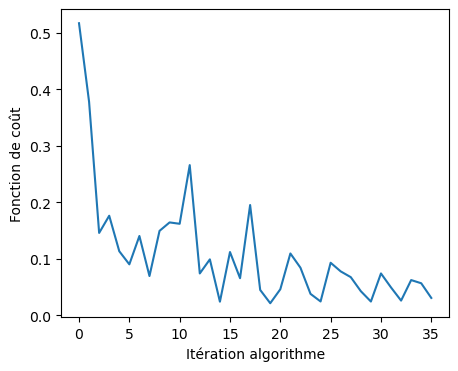

In [11]:
def plot_loss(loss, path=None):
    #function which plots the loss
    plt.figure(figsize=(5, 4))
    plt.plot(loss)
    plt.xlabel('Itération algorithme')
    plt.ylabel('Fonction de coût')
    if path:
        plt.savefig(path)
    else:
        plt.show()

plot_loss(loss_train)

# Performance de l'algorithme sur le jeu de test

In [12]:
################################
########FONCTION DE TEST########
################################


def test(model,data_loaders):
    
    with torch.no_grad():
        test_loss = []
        average_loss = 0 
        accuracy_list = []
        correct = 0

        for im_test, lab_test, ind_test in data_loaders['test']:

            im_test = im_test.view(-1, 1, 28, 28)
            im_test = im_test.type(torch.FloatTensor)

            pred_test = model(im_test)
            average_loss += F.cross_entropy(pred_test, lab_test,reduction='sum').item()
            pred = pred_test.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(lab_test.data.view_as(pred)).sum().item()

    average_loss /= len(data_loaders['test'].dataset)
    accuracy = 100. * correct / len(data_loaders['test'].dataset)
    accuracy_list.append(accuracy)
    
    return accuracy, accuracy_list, correct, average_loss, test_loss

In [13]:
accuracy, accuracy_list, correct, average_loss, test_loss = test(model,data_loaders)

print('\nTest set, average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    average_loss, correct, len(data_loaders['test'].dataset),
    accuracy))


Test set, average loss: 0.0531, Accuracy: 9832/10000 (98%)



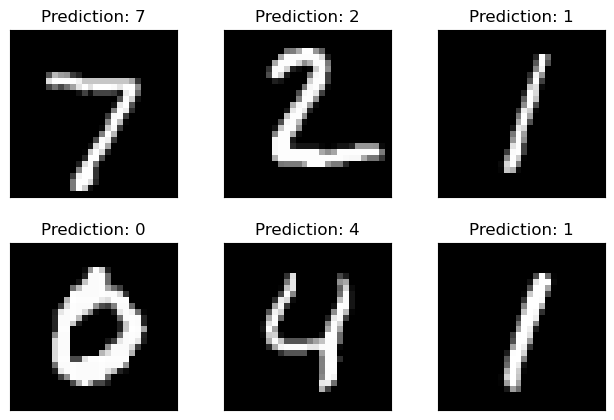

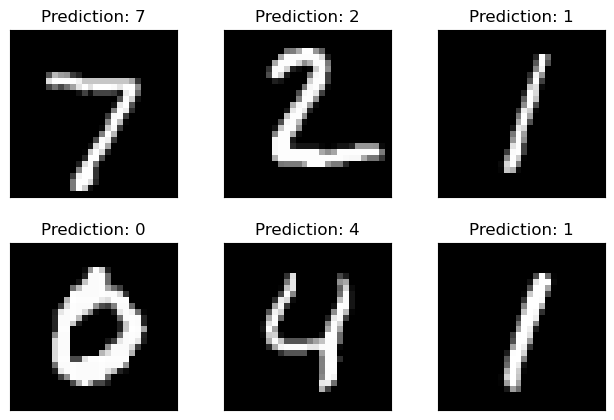

In [15]:
test_set = {"images": data_test.data, "labels": np.array(data_test.targets)} #jeu de test


fig = plt.figure()
for i in range(6):
    
    with torch.no_grad():
        im_test = test_set["images"][i]
        im_test = im_test.view(-1, 1, 28, 28)
        im_test = im_test.type(torch.FloatTensor)
        output = model(im_test)
    
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_set["images"][i], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1].item()))
    plt.xticks([])
    plt.yticks([])
    
fig